In [ ]:
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc,roc_auc_score
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from keras.utils import to_categorical
from keras.layers import Dense,Input,BatchNormalization,LSTM
from keras.layers import Flatten ,Dropout
from keras.models import Model
from keras.utils import to_categorical
from sklearn.metrics import roc_auc_score, auc
from sklearn.metrics import classification_report, confusion_matrix
from keras.layers import Dense , Conv1D,Input
import keras
import tensorflow as tf
from keras.utils import plot_model
import numpy as np
import pandas as pd

This note book contains :

  1 Load Data

  2 XGboost 

      hypertune learning rate
      hypertune estimators
      hypertune depth
      hypertune gamma
      best model
  3 Feed forward neural network

  4 Summary


In [ ]:
X_train,y_train = pickle.load(open("/content/pre_processed_train_data.pkl", 'rb')) 

In [ ]:
X_test,y_test = pickle.load(open("/content/pre_processed_test_data.pkl", 'rb')) 

## Define ALBERT Model

In [ ]:
#https://www.tensorflow.org/tutorials/text/classify_text_with_bert

In [ ]:
!pip3 install -q tensorflow-text

In [ ]:
!pip3 install -q tf-models-official

In [ ]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optmizer

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

In [ ]:
def getALBERT():


  preprocess_data = 'https://tfhub.dev/tensorflow/albert_en_preprocess/3'
  preprocessing_layer = hub.KerasLayer(preprocess_data, name='preprocessing')
  
  encode_data = 'https://tfhub.dev/tensorflow/albert_en_base/2'
  encoder = hub.KerasLayer(encode_data, trainable=False, name='ALBERT_encoder')


  #albert architecture 

  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')

  encoder_inputs = preprocessing_layer(text_input)
  
  outputs = encoder(encoder_inputs)
  
  vector_representation = outputs['pooled_output']
  
  return tf.keras.Model(text_input, vector_representation)

In [ ]:
albert = getALBERT()

In [ ]:
X_train = albert.predict(X_train)
X_test  = albert.predict(X_test)

In [ ]:
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.25)

## XGboost

In [ ]:
def batch_predict(clf, data):
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs

    y_data_pred = []
    tr_loop = data.shape[0] - data.shape[0]%1000
    # consider you X_tr shape is 49041, then your tr_loop will be 49041 - 49041%1000 = 49000
    # in this for loop we will iterate unti the last 1000 multiplier
    for i in range(0, tr_loop, 1000):
        y_data_pred.extend(clf.predict_proba(data[i:i+1000])[:,1])
    # we will be predicting for the last data points
    if data.shape[0]%1000 !=0:
        y_data_pred.extend(clf.predict_proba(data[tr_loop:])[:,1])
    
    return y_data_pred

In [ ]:
def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

### Learning Rate

In [ ]:
def XGBoost_learning_rate(X_tr,y_train) :

  print('LearningRate , Train ACU ','CV auc')

  learning_rate  = [0.1 ,.15 , 0.20 ,.25 , .3]

  for i in learning_rate :
    model = XGBClassifier(learning_rate=i)
    model.fit(X_tr,y_train)
    y_train_pred = batch_predict(model, X_tr)    
    y_cv_pred = batch_predict(model, X_cv)    

    print(i,'\t',roc_auc_score(y_train,y_train_pred),roc_auc_score(y_cv, y_cv_pred))

In [ ]:
XGBoost_learning_rate(X_train,y_train)

LearningRate , Train ACU  CV auc
0.1 	 0.6003754196369363 0.5922693568329459
0.15 	 0.6048926613625352 0.5947844608951303
0.2 	 0.6085611637146473 0.5968038502489561
0.25 	 0.6108313946311597 0.5972328227801353
0.3 	 0.6121587129938344 0.5974407029710659


In [ ]:
#best learning rate = .3

### Estimators

In [ ]:
def XGBoost_Estimators(estimator,X_tr,y_train) :

  print('Estimator  Train ACU  CV auc')

  #best learning rate = .3

  model = XGBClassifier(learning_rate=.3,n_estimators=estimator,n_jobs=-1)
  model.fit(X_tr,y_train)
  y_train_pred = batch_predict(model, X_tr)    
  y_cv_pred = batch_predict(model, X_cv)

  print(estimator,'\t',roc_auc_score(y_train,y_train_pred),roc_auc_score(y_cv, y_cv_pred))

In [ ]:
XGBoost_Estimators(50,X_train,y_train)

Estimator  Train ACU  CV auc
50 	 0.6014637799385296 0.5933572806740035


In [ ]:
XGBoost_Estimators(100,X_train,y_train)

Estimator  Train ACU  CV auc
100 	 0.6125178223234868 0.5962680348668511


In [ ]:
XGBoost_Estimators(150,X_train,y_train)

Estimator  Train ACU  CV auc
150 	 0.6189332505664534 0.6016389654444306


In [ ]:
XGBoost_Estimators(200,X_train,y_train)

Estimator  Train ACU  CV auc
200 	 0.6247981831891583 0.6012021543247924


### Depth

In [ ]:
def XGBoost_depth(X_tr,y_train) :

  print('Depth  Train ACU ','CV auc')

  depths = [3,6]

  # learning rate = .3
  # estimators = 150

  for i in depths :

    model = XGBClassifier(learning_rate=.3,n_estimators=150,n_jobs=-1,max_depth=i)
    model.fit(X_tr,y_train)
    y_train_pred = batch_predict(model, X_tr)    
    y_cv_pred = batch_predict(model, X_cv)

    print(i,'\t',roc_auc_score(y_train,y_train_pred),roc_auc_score(y_cv, y_cv_pred))

In [ ]:
XGBoost_depth(X_train,y_train)

Depth  Train ACU  CV auc
3 	 0.6193949235506246 0.600328480674337
6 	 0.6992829830773801 0.5866372657500931


### Gamma

In [ ]:
def XGBoost_Gamma(X_tr,y_train) :

  print('Gamma  Train ACU ','CV auc')

  gamma = [.1,.2]

  # learning rate = .3
  # estimators = 150
  # depth = 3

  for i in gamma :

    model = XGBClassifier(learning_rate=.3,n_estimators=150,n_jobs=-1,max_depth=3,gamma=i)
    model.fit(X_tr,y_train)
    
    y_train_pred = batch_predict(model, X_tr)    
    y_cv_pred = batch_predict(model, X_cv)

    print(i,'\t',roc_auc_score(y_train,y_train_pred),roc_auc_score(y_cv, y_cv_pred))

In [ ]:
XGBoost_Gamma(X_train,y_train)

Gamma  Train ACU  CV auc
0.1 	 0.6191096120193209 0.6007508722211479
0.2 	 0.6191096120193209 0.6007508722211479


### Best Model

In [ ]:
def best_model(model) :

  model.fit(X_train, y_train)

  y_train_pred = batch_predict(model, X_train)    
  y_test_pred = batch_predict(model, X_test)

  train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
  test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

  plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
  plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
  plt.legend()
  plt.xlabel("hyperparameter")
  plt.ylabel("AUC")
  plt.title("ERROR PLOTS")
  plt.grid()
  plt.show()


  print("="*100)
  best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)

  print('Best threshold ',best_t)
  print("Train confusion matrix")
  print(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)))
  print("Test confusion matrix")
  print(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))

  tn ,fp,fn,tp = confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)).ravel()

  recall = tp / (tp+fn)
  precision = tp/(tp+fp)

  print('\nRecall ',recall)
  print('\nPrecision',precision)
  print('\nF1 Score',f1_score(y_test, predict_with_best_t(y_test_pred, best_t),average='macro'))

  return model

In [ ]:
# learning rate = .3
# estimators = 150
# depth = 3

xgb_model = XGBClassifier(learning_rate=.3,n_estimators=150,n_jobs=-1,max_depth=3,gamma=0)

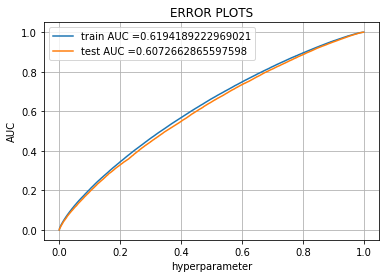

the maximum value of tpr*(1-fpr) 0.3413973335738164 for threshold 0.494
Best threshold  0.49391156
Train confusion matrix
[[204621 145388]
 [145607 204383]]
Test confusion matrix
[[32277 24463]
 [23755 32985]]

Recall  0.5813359182234755

Precision 0.5741714245926751

F1 Score 0.5750803934135935


In [ ]:
xgb_model = best_model(xgb_model)

In [ ]:
#SAVE the best model trained

pickle.dump(xgb_model,open("xgb.pkl", 'wb'))

## 3 Feed Forward Neural Network

In [ ]:
def auc(y_true, y_pred):
    return tf.py_function(roc_auc_score, (y_true, y_pred), tf.double)

In [ ]:
from keras import backend as K

def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall_ = true_positives / (possible_positives + K.epsilon())
    return recall_

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision_ = true_positives / (predicted_positives + K.epsilon())
    return precision_

def f1(y_true, y_pred):
    precision_ = precision(y_true, y_pred)
    recall_ = recall(y_true, y_pred)
    return 2*((precision_*recall_)/(precision_+recall_+K.epsilon()))


In [ ]:
input = Input(shape = (768,))

x = Dense(512,activation='relu') (input)
x = BatchNormalization()(x)
x = Dropout(.5)(x)

x = Dense(128,activation='relu') (x)
x = BatchNormalization()(x)
x = Dropout(.5)(x)

x = Dense(64,activation='relu') (x)
x = BatchNormalization()(x)
x = Dropout(.5)(x)

x = Dense(32,activation='relu') (x)
x = BatchNormalization()(x)
x = Dropout(.5)(x)

x = Dense(16,activation='relu') (x)
x = BatchNormalization()(x)
x = Dropout(.5)(x)

out = Dense(2,activation='softmax')(x)

ffnn_model = Model(input,out)

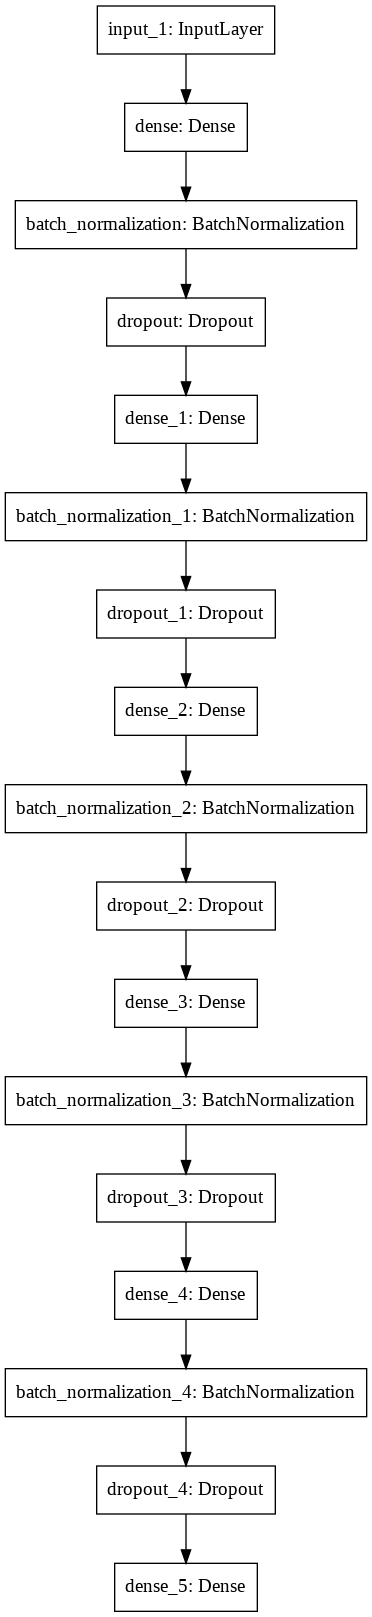

In [ ]:
plot_model(ffnn_model)

In [ ]:
ffnn_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 768)]             0         
_________________________________________________________________
dense (Dense)                (None, 512)               393728    
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0     

In [ ]:
ffnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc',auc,f1,precision, recall])

In [ ]:
ffnn_model.fit(X_train,to_categorical(y_train), batch_size=128,
          epochs=15, validation_data=(X_test,to_categorical(y_test)))

Epoch 1/15
5469/5469 [==============================] - 38s 7ms/step - loss: 0.7204 - acc: 0.5063 - auc: 0.5079 - f1: 0.5063 - precision: 0.5063 - recall: 0.5063 - val_loss: 0.6888 - val_acc: 0.5354 - val_auc: 0.5807 - val_f1: 0.5354 - val_precision: 0.5354 - val_recall: 0.5354
Epoch 2/15
5469/5469 [==============================] - 35s 6ms/step - loss: 0.6853 - acc: 0.5558 - auc: 0.5739 - f1: 0.5558 - precision: 0.5558 - recall: 0.5558 - val_loss: 0.6866 - val_acc: 0.5432 - val_auc: 0.5912 - val_f1: 0.5432 - val_precision: 0.5432 - val_recall: 0.5432
Epoch 3/15
5469/5469 [==============================] - 35s 6ms/step - loss: 0.6827 - acc: 0.5623 - auc: 0.5841 - f1: 0.5623 - precision: 0.5623 - recall: 0.5623 - val_loss: 0.6912 - val_acc: 0.5416 - val_auc: 0.5967 - val_f1: 0.5416 - val_precision: 0.5416 - val_recall: 0.5416
Epoch 4/15
5469/5469 [==============================] - 35s 6ms/step - loss: 0.6818 - acc: 0.5646 - auc: 0.5879 - f1: 0.5646 - precision: 0.5646 - recall: 0.5646 -

##4  Summary

XGBOOST :

auc = 60.7         recall  0.5813
precision 0.574    f1 Score 0.57

Feed forward neural network :

auc: 0.6082        recall: 0.5372     
precision: 0.5372  f1: 0.5372 


XGboost performs better in comparsion with FFNN